In [1]:
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from commpy.utilities  import upsample
from optic.dsp.core import firFilter, pulseShape
from optic.core import parameters
import scipy.signal as signal
from scipy.ndimage import shift
from scipy.constants import h

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from models.laser_dfb import laser_dfb

In [4]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [5]:
figsize(9,6)
plt.style.use('bmh')

### Simulation

In [6]:
laser_dfb_parameters = parameters()
laser_dfb_parameters.noise_terms = True
laser_dfb_parameters.v       = 1.0       # [cm3]  active layer volume
laser_dfb_parameters.tau_n   = 0.33e-9   # [s]    electron lifetime
laser_dfb_parameters.a0      = 2.50e-6   # [cm2]  active layer gain coefficient
laser_dfb_parameters.vg      = 4.52e+9   # [cm/s] group velocity
laser_dfb_parameters.n_t     = 8.2e6     # [cm-1] carrier density at transparency
laser_dfb_parameters.epsilon = 4.58e-8   # [cm3] gain compression factor
laser_dfb_parameters.tau_p   = 7.15e-12  # [s] photon lifetime
laser_dfb_parameters.gamma   = 1.0       # mode confinement factor
laser_dfb_parameters.beta    = 3.54e-5   # fraction of spontaneous emission coupling
laser_dfb_parameters.alpha   = 1.55      # linewidth enchancement factor
laser_dfb_parameters.sigma   = 2e-20     # gain cross section
laser_dfb_parameters.i_bias  = 0.0129    # [A] i_bias
laser_dfb_parameters.i_max   = 0.0300    # [A] i_max
laser_dfb_parameters.eta_0   = 0.21      # total differential quantum efficiency
laser_dfb_parameters.lmbd    = .5*1554.3e-9 # [m] wavelength

In [7]:
# simulation parameters
SpS = 256
Rs = 2.5e9   # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

In [8]:
# generate pseudo-random bit sequence
bitsTx = [0,1,0,1,0] 

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])
t = np.arange(0,SpS*len(bitsTx))*Ts

In [9]:
# RC filter
def rc_filter(R, C, Fs, filter_type):
    if (1/(2*np.pi*R*C) > Fs/2):
        ('This analog filter cannot be realized with this sample rate')    
    # Default to allpass if invalid type is selected
    b = [1, 0]
    a = [1, 0]
    # Constants
    RC = R * C
    T  = 1 / Fs
    # Analog Cutoff Fc
    w = 1 / (RC)
    # Prewarped coefficient for Bilinear transform
    A = 1 / (np.tan((w*T) / 2))
    if(filter_type=='high'):
        b[0] = (A)     / (1 + A)
        b[1] = -b[0]
        a[1] = (1 - A) / (1 + A)
    if(filter_type=='low'):
        b[0] = (1)     / (1 + A)
        b[1] = b[0]
        a[1] = (1 - A) / (1 + A)
    return a,b
# Filter parameters
R = 59.17
C = 1.e-12
# Filter cut-off
f_cut = 1./(2.*np.pi*R*C)
# Signal filtering
a,b=rc_filter(R, C, Fs, 'low')
zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, sigTx, zi=zi*sigTx[0])

C:\Users\Adolfo\anaconda3\envs\laser\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


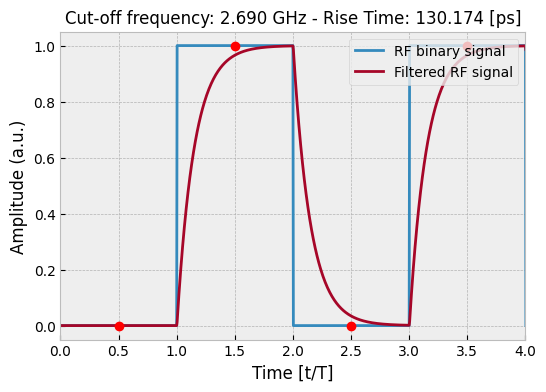

In [10]:
# Plot bits, rf signal and filtered signal
plt.figure(figsize=(6,4))
plt.plot(t*Rs, sigTx, label = 'RF binary signal', linewidth=2)
plt.plot(t*Rs, z, label = 'Filtered RF signal', linewidth=2)
plt.plot(t[int(SpS/2)::SpS]*Rs, bitsTx, 'ro')
plt.title('Cut-off frequency: %.3f GHz - Rise Time: %.3f [ps]'%(1e-9*f_cut,2.2*R*C*1e12), fontsize=12)
plt.ylabel('Amplitude (a.u.)')
plt.xlabel('Time [t/T]')
plt.xlim([0,4])
plt.legend(loc='upper right')
plt.grid(True)

In [11]:
#laser_dfb_parameters.noise_terms = False
laser = laser_dfb(laser_dfb_parameters)
sol = laser.solve(t, z)

C:\Users\Adolfo\Documents\GitHub\lasers\models\laser_dfb.py:119: RuntimeWarning: invalid value encountered in sqrt
  fs = np.random.randn()*np.sqrt(2*dss/self.t_step)
C:\Users\Adolfo\Documents\GitHub\lasers\models\laser_dfb.py:121: RuntimeWarning: invalid value encountered in sqrt
  fp = np.random.randn()*np.sqrt(2*dpp/self.t_step)


I_threshold: 9.990 mA
I_on: 42.865 mA
I_off: 12.900 mA


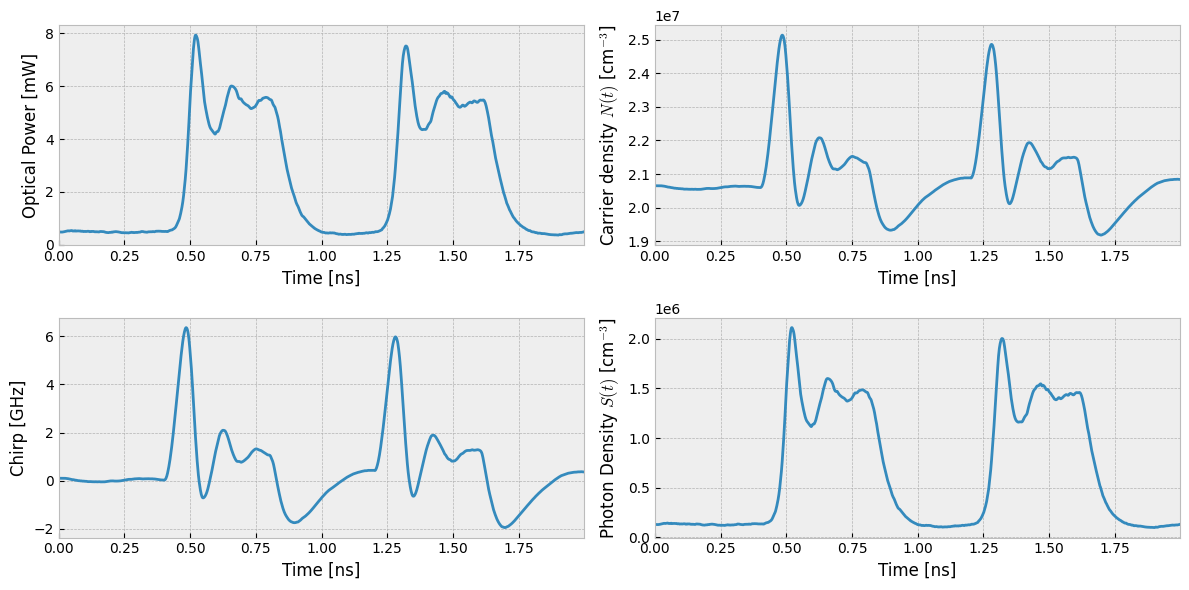

In [12]:
laser.plot()
print('I_threshold: %.3f mA'%(1e3*laser.ith))
print('I_on: %.3f mA'%(1e3*np.real(laser.current.max())))
print('I_off: %.3f mA'%(1e3*np.real(laser.current.min())))

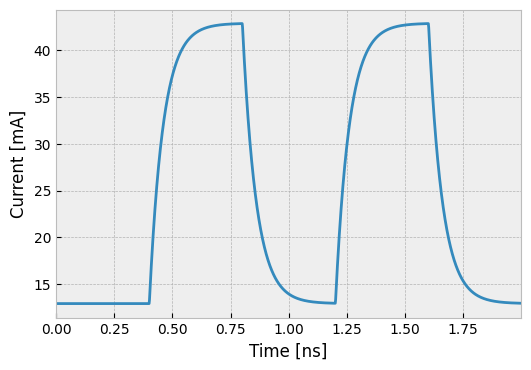

In [13]:
plt.figure(figsize=(6,4))
plt.plot(1e9*laser.t, 1e3*laser.current)
plt.xlabel('Time [ns]')
plt.ylabel('Current [mA]')
plt.xlim([1e9*t.min(), 1e9*t.max()])
plt.grid(True)

### RIN and Linewidth

In [14]:
# simulation parameters
SpS = 16
Rs = 3.125e9   # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

In [15]:
Ts*1e12

20.0

In [16]:
# generate bit sequence of "0"
bitsTx = np.zeros(2**12)

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)
sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])
t = np.arange(0,SpS*len(bitsTx))*Ts

In [17]:
sol = laser.solve(t, sigTx)

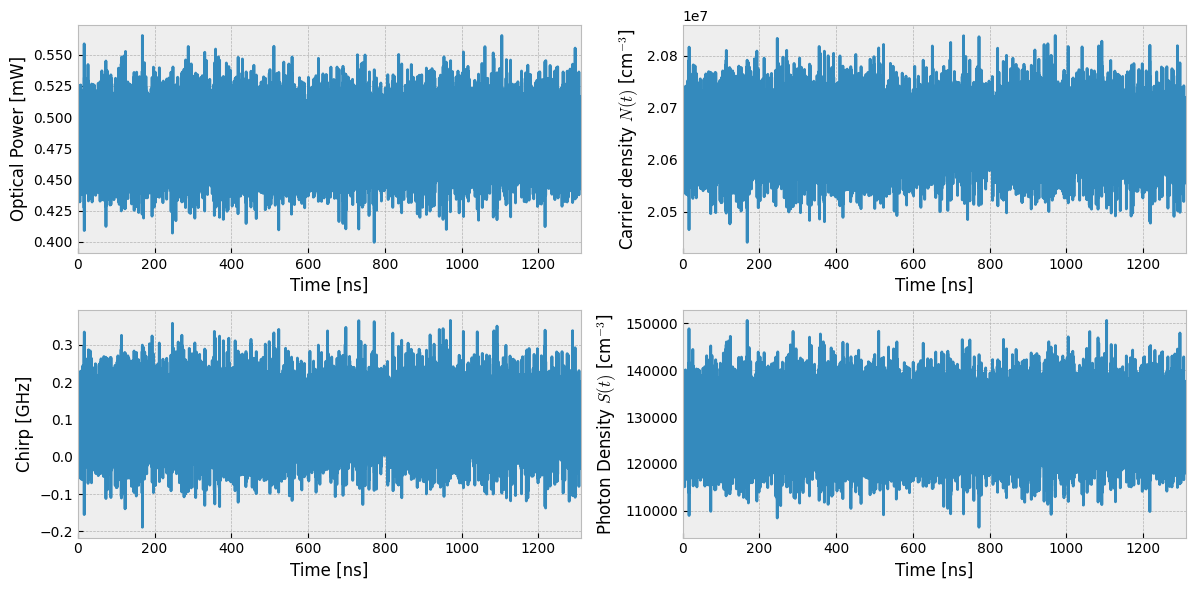

In [18]:
ax = laser.plot()

(0.75, 1.15)

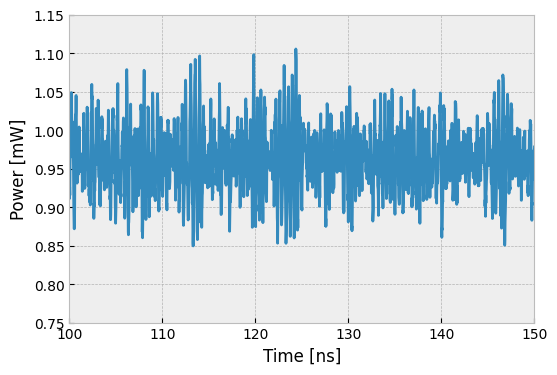

In [19]:
p_t = laser.eta_0*h*laser.freq_0/laser.tau_p * laser.S # Equation [13] of reference.
plt.figure(figsize=(6,4))
plt.plot(1e9*laser.t, 1e3*p_t)
plt.xlabel('Time [ns]')
plt.ylabel('Power [mW]')
plt.xlim([100,150])
plt.ylim([.75,1.15])

In [20]:
indx = np.squeeze(np.argwhere(t > 100e-9))
p_t = p_t[indx[0]:]
p_mean  = np.mean(p_t)
p_delta = p_t - p_mean

In [21]:
# Get RIN
F, P = signal.periodogram(p_delta, Fs, scaling='density')
rin = P/p_mean**2
# Filter
b = signal.firwin(numtaps = 50, cutoff = 0.01, window='hamming')
rin_t = firFilter(b, rin)

(0.01, 10)

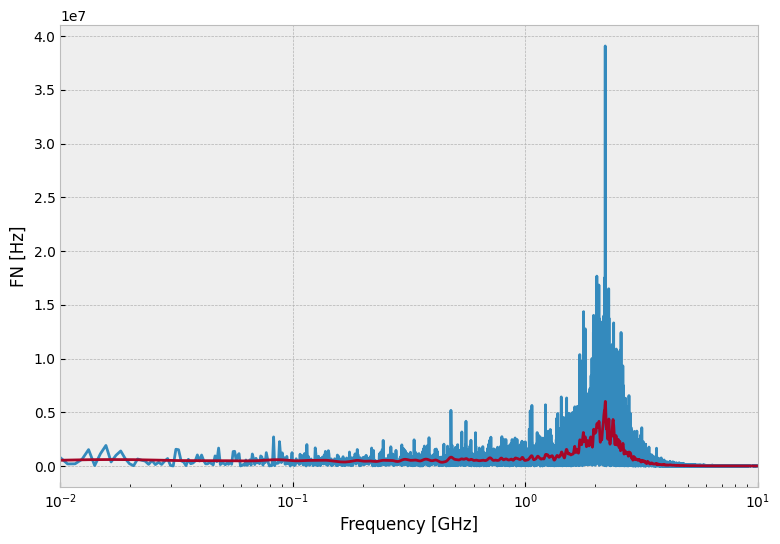

In [22]:
# Get FN
Fc, C = signal.periodogram(laser.chirp[indx[0:]], Fs, scaling='density')
# Filter
b = signal.firwin(numtaps = 50, cutoff = 0.01, window='hamming')
phase_noise = firFilter(b, C)
# Plot
plt.semilogx(1e-9*Fc,C)
plt.semilogx(1e-9*Fc,phase_noise)
plt.xlabel('Frequency [GHz]')
plt.ylabel('FN [Hz]')
plt.xlim([0.01,10])

In [23]:
# Analitical RIN
from scipy.constants import e
I = laser_dfb_parameters.i_bias
g = 1.13e4
laser.epsilon = laser.epsilon/laser.v
laser.n_t = laser.n_t*laser.v

In [24]:
a = e*(laser.epsilon + g*laser.tau_n)
b = e+g*laser.tau_p*((1-laser.beta)*laser.n_t*e - laser.tau_n*I)-laser.beta*laser.epsilon*laser.tau_p*I
c = -laser.beta*laser.tau_p*I

In [25]:
S = (-b + np.sqrt(b**2-4*a*c))/(2*a)
N = (laser.tau_n/e)*((I*(1+laser.epsilon*S)+g*laser.n_t*e*S)/(1+laser.epsilon*S+g*S*laser.tau_n))

In [26]:
Y = 1/laser.tau_n + 1/laser.tau_p + g/(1+laser.epsilon*S) * (S-(N-laser.n_t)/(1+laser.epsilon*S))
Z = 1/(laser.tau_n*laser.tau_p)+ g/(1+laser.epsilon*S) * (S/laser.tau_p - ((1-laser.beta)/laser.tau_n) * (N-laser.n_t)/(1+laser.epsilon*S))
A = ((1/laser.tau_n**2)*((1-laser.beta)**2+laser.beta/S)+g/(1+laser.epsilon*S)*(2/laser.tau_n + (S/laser.beta) * (g/(1+laser.epsilon*S))))**-1
R = 2*(laser.tau_p**2)*((1+laser.epsilon*S)**2)*N
R = R * (laser.beta*(S*(1-laser.beta)**2+laser.beta)*(1+laser.epsilon*S)**2+g*S*laser.tau_n*(g*S*laser.tau_n+2*laser.beta*laser.epsilon*S+2*laser.beta))
R = R/(S**2*laser.tau_n*(laser.tau_p*g*(1-laser.beta)*(N-laser.n_t)-(1+laser.epsilon*S)*(g*S*laser.tau_n+(1+laser.epsilon*S)))**2)

In [27]:
f = np.linspace(50e6,8e9,1000)
w = 2*np.pi*f
RIN = (R*Z**2*(1+A*w**2))/(Z**2+(Y**2-2*Z)*w**2+w**4)

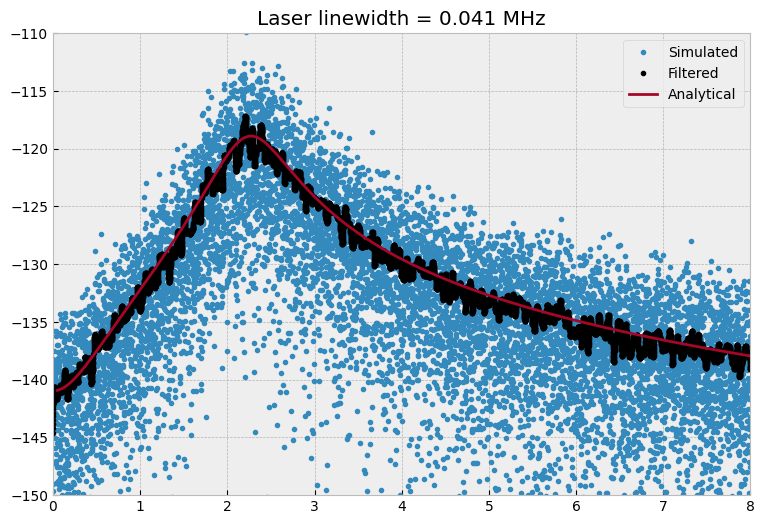

In [28]:
# Compare 
plt.plot(1e-9*F, 10*np.log10(rin),'.',label='Simulated')
plt.plot(1e-9*F, 10*np.log10(rin_t),'k.',label='Filtered')
plt.plot(1e-9*f, 10*np.log10(RIN),label='Analytical')
plt.title('Laser linewidth = %.3f MHz'%(1e-6*phase_noise[0]/(2*np.pi)))
plt.xlim([0,8])
plt.ylim([-150,-110])
plt.legend()